In [ ]:
import os
from roboflow import Roboflow

api_key = os.getenv('API_KEY')
workspace = os.getenv('WORKSPACE')
project_name = os.getenv('PROJECT')
project_version = os.getenv('PROJECT_VERSION')
dataset_format = os.getenv('DATASET_FORMAT')

home_dir = os.getcwd()
dataset_path = os.path.join(home_dir, 'dataset')

if not os.path.exists(dataset_path) or not os.listdir(dataset_path):  # Only download if the folder is empty or doesn't exist
    os.makedirs(dataset_path, exist_ok=True)
    
    os.chdir(dataset_path)

    try:
        rf = Roboflow(api_key=api_key)
        project = rf.workspace(workspace).project(project_name)
        version = project.version(project_version)
        dataset = version.download(dataset_format)
        print(f"Dataset downloaded successfully in {dataset_path}")
    except Exception as e:
        print(f"Error downloading the dataset: {e}")

    os.chdir(home_dir)
else:
    print(f"Dataset directory already exists at {dataset_path}. Skipping download.")

os.chdir(home_dir)


In [1]:
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

In [2]:
import os
import sys
import random
import math
import re
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class LoculesConfig(Config):
    NAME = "locules"
    BACKBONE = "resnet50"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2 + 1
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 640
    
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001

config = LoculesConfig()
config.display()
    


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [4]:
from PIL import Image, ImageDraw
import json

class DurianLoculeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "locules"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)
        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

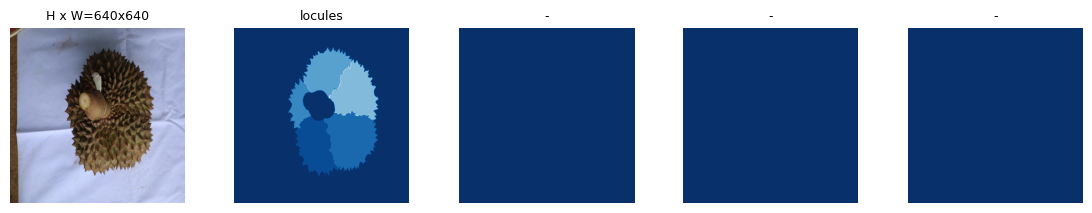

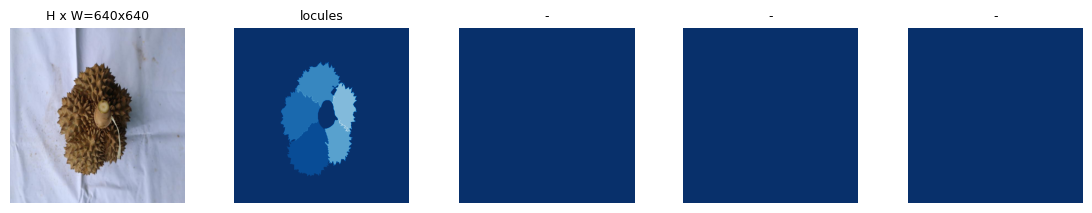

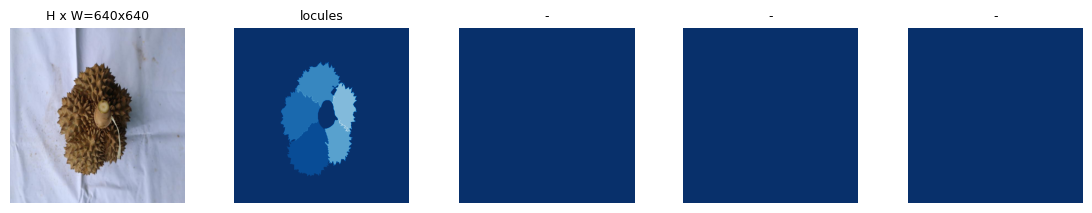

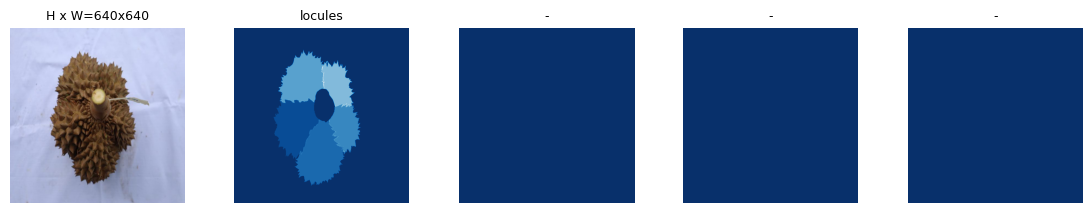

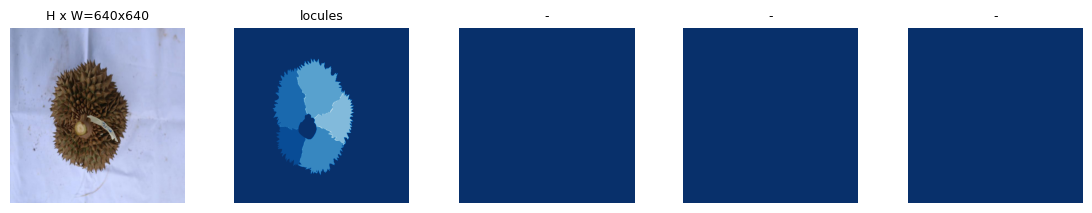

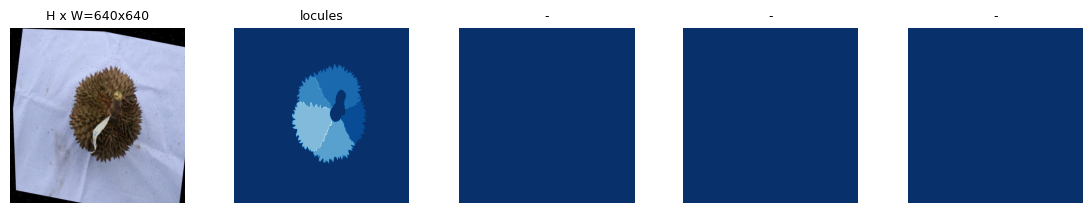

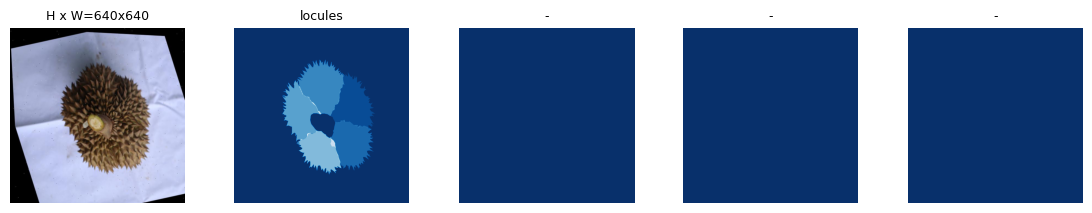

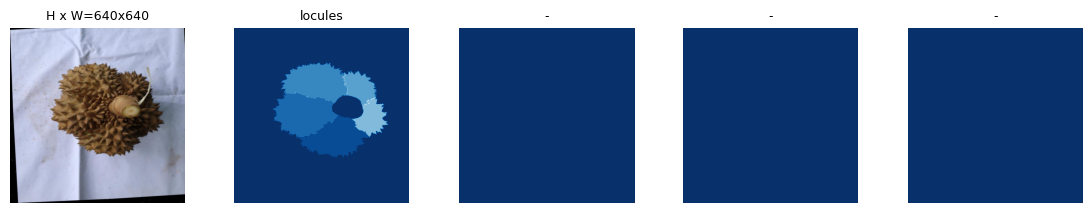

In [5]:
import numpy as np

dataset_train = DurianLoculeDataset()
dataset_train.load_data('./dataset/dataset/locule-4/test/_annotations.coco.json', './dataset/dataset/locule-4/test/')
dataset_train.prepare()

dataset_val = DurianLoculeDataset()
dataset_val.load_data('./dataset/dataset/locule-4/train/_annotations.coco.json', './dataset/dataset/locule-4/train/')
dataset_val.prepare()

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
print(os.listdir())

In [ ]:
import os
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
print(MODEL_DIR)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Train from coco checkpoint
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')